Rezultatele circuitului:
{'0010': 2, '1011': 962, '0110': 4, '1111': 6, '1101': 3, '1100': 2, '0001': 5, '0101': 4, '0000': 2, '1010': 4, '0100': 3, '0011': 2, '1001': 1}


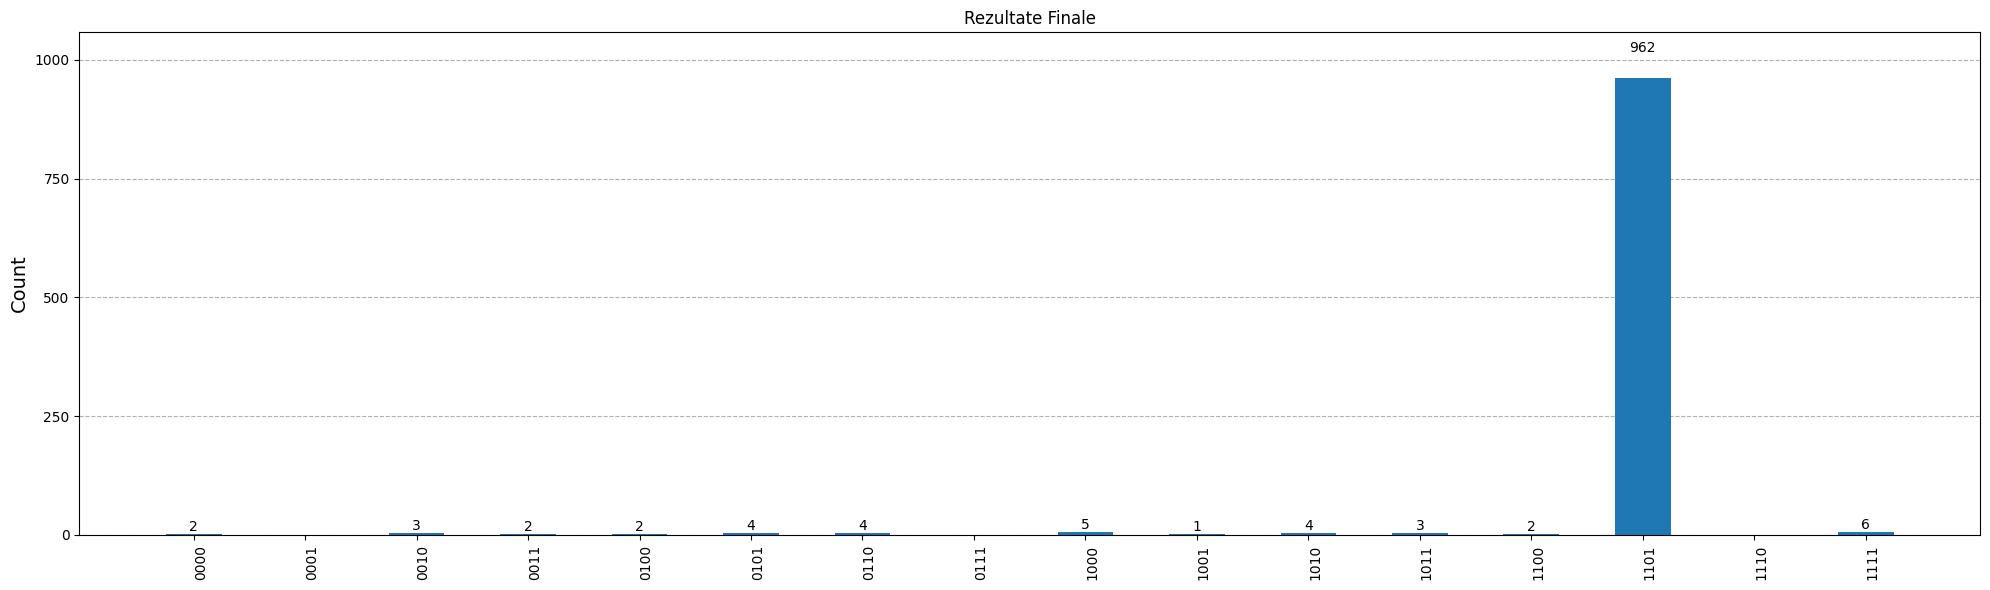

In [ ]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import MCXGate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

# Parametri
target_state = '1101'
n_qubits = len(target_state)

def grover_oracle(n, target):
    oracle = QuantumCircuit(n)
    
    # Aplicam X pe bitii 0 ca sa transforme în starea |111...1⟩ doar cand targetul e potrivit
    for i, bit in enumerate(target):
        if bit == '0':
            oracle.x(i)
    
    # Aplicam multi-controlled-Z
    oracle.h(n - 1)
    oracle.mcx(list(range(n - 1)), n - 1)
    oracle.h(n - 1)
    
    # Echivalentul al unui MCZ gate cu control_qubits = primii n-1, si target qubit = n 
    # un MultiControlledZ gate face ca -> daca toti control qubitii sunt 1 atunci aplica Z pe qubitiul tinta
    # Deci MCZ-ul are efect doar daca starea de intrare este |1111111> si aceasta il face -|11111111>
    # Echivalent cu |x> = { -|x> daca x = 1111111 , |x> altfel}

    # Revine cu X-urile
    for i, bit in enumerate(target):
        if bit == '0':
            oracle.x(i)
    
    # In final inversam iarasi bitii pe care i-am inversat inapoi
    # Deci in final , daca starea care trece prin oracol este diferita de target aceasta revine la normal
    # Si daca starea care trece prin oracol este targetul, aceasta va deveni -target

    return oracle

def diffusion_operator(n):
    diffuser = QuantumCircuit(n)

    diffuser.h(range(n))
    diffuser.x(range(n))

    # Multi controlled Z gate - inverseaza doar starea |111111>
    diffuser.h(n - 1)
    diffuser.mcx(list(range(n - 1)), n - 1)
    diffuser.h(n - 1)

    diffuser.x(range(n))
    diffuser.h(range(n))

    return diffuser

# Construieste circuitul Grover
qc = QuantumCircuit(n_qubits, n_qubits)
qc.h(range(n_qubits))

# Calculeaza numarul de iteratii necesar
N = 2 ** n_qubits
iterations = int(np.floor(np.pi / 4 * np.sqrt(N)))

oracle = grover_oracle(n_qubits, target_state)
diffuser = diffusion_operator(n_qubits)


# Grover iterations
for _ in range(iterations):
    qc.append(oracle.to_gate(label="Oracle"), range(n_qubits))
    qc.append(diffuser.to_gate(label="Diffuser"), range(n_qubits))


# Masuratori
qc.measure(range(n_qubits), range(n_qubits))


# Simuleaza circuitul
simulator = AerSimulator()
qc_transpiled = transpile(qc, simulator)
job = simulator.run(qc_transpiled, shots=1000) # 1000 - de cate ori rulam circuitul ( pentru masuratori )
result = job.result()
counts = result.get_counts()

# Afisam rezultate
print("Rezultatele circuitului:")
print(counts)


## PARTEA DE AFISAJ
# Generam toate starile posibile
all_states = [''.join(bits) for bits in product('01', repeat=n_qubits)]
# Adaugam starile lipsa cu 0 daca nu exista în counts
full_counts = {state: counts.get(state, 0) for state in all_states}
# Inversam bitii pentru ordinea dorita
full_counts_flipped = {state[::-1]: count for state, count in full_counts.items()}

# Plotam histograma completa
plot_histogram(full_counts_flipped, title="Rezultate Finale", figsize=(20,6))
plt.xticks(rotation=90)  # ca sa incapa toate etichetele
plt.tight_layout()
plt.show()
